# Modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
import cmocean

from shapely.geometry import Polygon, Point
import shapely 

# /Topography File Path and Grid Information

In [2]:
bathyFilePath = 'testBathy.txt'

# Origin point of grid
x0 = 0
y0 = 0

# Grid Resolution
dx = 0.5
dy = 0.5

# Maximum number of points to plot in a single direction 
maxLinearPlotPoints = 200

# Plotting Functions

In [3]:
font = {'family' : 'DejaVu Sans',
    'weight' : 'normal',
    'size'   : 14}

matplotlib.rc('font', **font)

# Code courtesy of Chris Williams, http://chris35wills.github.io/matplotlib_diverging_colorbar/
class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)
    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))   
      
def pcolorAutoScale( ax ,x, y , data, cmap, vMin=None, vMax=None):
    
    if (vMax == None):    
        vMax = np.max( data )
    if (vMin == None):
        vMin = np.min( data )

    return ax.pcolor(x, y, data, cmap=cmap, vmin=vMin, vmax=vMax, norm=MidpointNormalize(midpoint=0,vmin=vMin, vmax=vMax) )


def plotBathy( ax, x, y, z , stride=1):
    
    def getLength(s):
        sMax = np.max(s)
        sMin = np.min(s)
        sL = sMax - sMin 
        return sL 
    
    cmBathy = cmocean.cm.topo 
    cmBathyContour = cmocean.cm.matter

    maxLen = 12
    
    xL = getLength(x)
    yL = getLength(y) 

    cp = pcolorAutoScale(ax,x[::stride],y[::stride],z[::stride,::stride],cmBathy )
    
    if ( xL > yL ):
        cb = fig.colorbar(cp , ax=ax, orientation='horizontal')
    else:
        cb = fig.colorbar(cp , ax=ax, orientation='vertical')
        
    cb.set_label('Topology/Bathymetry (m)')

    ax.set_aspect('equal', 'box')
    
    CS = ax.contour(x , y, z, 10, cmap=cmBathyContour )
    plt.clabel(CS, inline=1, fontsize=14)
    
    ax.set_xlabel( "x (m)")    
    ax.set_ylabel( "y (m)")
    

# Loading data and building grid

Grid Dimensions: nGlob=90, mGlob=120, stride=1
Plot Dimensions: nGlob=90, mGlob=120


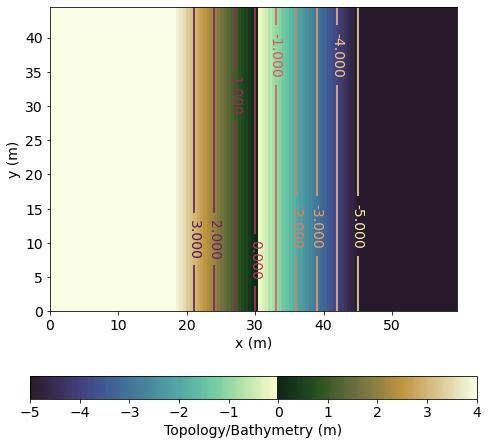

In [4]:
# Loading data
funwaveBathy = np.loadtxt(bathyFilePath) 

# Reversing FUNWAVE sign change, easier to work with
bathy = -funwaveBathy
[nGlob, mGlob] = funwaveBathy.shape

# Constructing equispaced grid  
x = np.arange(0,mGlob)*dx + x0
y = np.arange(0,nGlob)*dy + y0

# Computing stride based on max linear plot size
nMax = max(nGlob,mGlob)

stride = int(nMax/maxLinearPlotPoints)
if ( stride < 1 ): stride = 1
    
nGlobPlot = int( nGlob/stride )
mGlobPlot = int( mGlob/stride )

print( "Grid Dimensions: nGlob=%d, mGlob=%d, stride=%d" % (nGlob, mGlob, stride) )
print( "Plot Dimensions: nGlob=%d, mGlob=%d" % (nGlobPlot,mGlobPlot) )

# Plotting topography/bathymetry
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)


plotBathy( ax, x, y, bathy, stride )

# Breakwater Functions

In [5]:

def get1DBox( S, s0, L ):
    return 1 - (np.abs(S-s0)/(L/2) < 1) 
 
def get1DTrap( S, s0, L ):

    return np.minimum( np.abs(S-s0)/(L/2) , 1 )

def getPrism( x0, y0, x, y, length, baseWidth, topWidth, height, angle, angleRot, bottomBathy ):

    slopeAngle = np.arctan( height/((baseWidth-topWidth)/2)   )
    projectedHeight = baseWidth/2*np.tan(slopeAngle)  
    
    [X,Y] = np.meshgrid(x,y)
    
    U = (X-x0)*np.cos(-angleRot) - (Y-y0)*np.sin(-angleRot)
    V = (X-x0)*np.sin(-angleRot) + (Y-y0)*np.cos(-angleRot)

    sol = projectedHeight*(1 - np.maximum(get1DTrap(U, 0, baseWidth) , get1DBox( V, 0, length ) ) )
    
    sol = np.minimum( sol , height  ) 
    
    sol = np.maximum( sol , bottomBathy )
     
    return sol 



def getBaseShape( width , length, angleRot, x0, y0 ):
    # Vertices of bottom of breakwater 
    vetrices = [
        ( -width/2, -length/2 ),
        (  width/2, -length/2 ),
        (  width/2,  length/2 ),
        ( -width/2,  length/2 )
    ]

    baseShape       = Polygon( vetrices )
    rotShape        = shapely.affinity.rotate(baseShape, angleRot , origin='center', use_radians=True)
    shiftedRotShape = shapely.affinity.translate(rotShape, xoff=x0, yoff=y0, zoff=0.0 )
    
    return shiftedRotShape

def getBasePoints( shape , x , y ):
    
    idxs = [] 
    # Extracting indices or points in array
    for j in range(len(y)):

        for i in range(len(x)):

            pt = Point( ( x[i] , y[j])  )

            if shape.contains( pt ):
                idxs.append( (j,i) )

    # Converting from list of tuples indices, (j,i), to tuple 
    # of arrays, i.e, [ (j_0,i_0), (j_1,i_1), ..., (j_n,i_n) ] =>
    #                 ( [j_0,j_1,...,j_n], [i_0,i_1,...,i_n] )
    idxs = tuple(np.array(idxs).T)

    return idxs

def addBreakWater( breakwater, bathy ):
    
    x1 = breakwater['x1']
    x2 = breakwater['x2']
    y1 = breakwater['y1']
    y2 = breakwater['y2']
    
    angle = np.arctan2( y2 - y1 , x2 - x1)
    angleRot = angle - np.pi/2

    baseWidth = breakwater['baseWidth'] 
    topWidth = breakwater['topWidth'] 

    length = ((x2-x1)**2 + (y2-y1)**2)**0.5
    
    x0 = x1 + np.cos(angle)*length/2
    y0 = y1 + np.sin(angle)*length/2

    baseShape = getBaseShape( baseWidth , length, angleRot, x0, y0  )
    idxs = getBasePoints( baseShape , x , y )
    
    minDepth = np.min( bathy[idxs] )
    
    height = breakwater['heightAboveWater'] - minDepth
    
    if ( height > 0 ):

        bottomBathy = np.zeros(bathy.shape)
        bottomBathy[idxs] = bathy[idxs] - minDepth
        
        bathy[idxs] = minDepth
        bathy += getPrism( x0, y0, x, y, length, baseWidth, topWidth, height, angle, angleRot, bottomBathy )

# Adding breakwater to bathy 

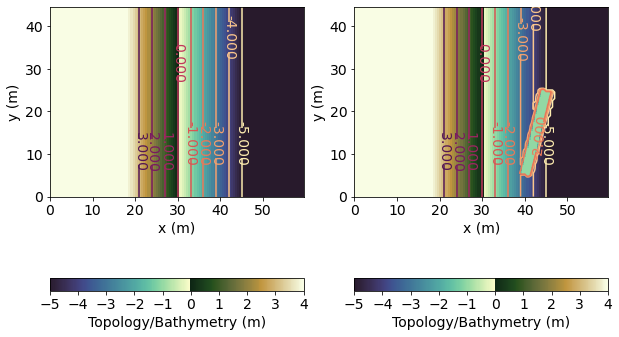

In [6]:
breakWater1 = {
    'x1'              : 40,
    'y1'              :  5,
    'x2'              : 45,
    'y2'              : 25,
    "heightAboveWater": -1,
    "baseWidth"       : 4,
    "topWidth"        : 2     
}


breakWaters = [ breakWater1 ]

bathyBreakwaters = bathy.copy()

for breakwater in breakWaters:
    addBreakWater( breakwater, bathyBreakwaters )


fig, axs = plt.subplots(1,2)

fig.set_size_inches(10, 10)
axs=axs.flatten()


plotBathy( axs[0], x, y, bathy, stride )
plotBathy( axs[1], x, y, bathyBreakwaters, stride )


# Saving FUNWAVE Bathy File

In [10]:
outputFilePath = 'bathyBreakwaters.txt'
funwaveBathyBreakwaters= -bathyBreakwaters

np.savetxt( outputFilePath, funwaveBathyBreakwaters)